In [2]:
import matplotlib.pyplot as plt
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
import os
import glob
import pandas as pd
import pickle
import time
import warnings
import tensorflow as tf
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc,roc_auc_score,precision_recall_curve,average_precision_score,f1_score,precision_score,recall_score
import scipy
warnings.filterwarnings("ignore")
import transformers as ppb
import huggingface_hub as hf_hub
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW, get_linear_schedule_with_warmup, AutoModel

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
2022-10-29 17:37:38.656739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-29 17:37:38.761584: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-29 17:37:39.299494: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-29 17:37:39.299542: W tensorflow/

In [3]:
#download audio dataset
if not os.path.exists('./ESC-50-master'):
    if not os.path.exists('./master'):
        !wget https://codeload.github.com/karolpiczak/ESC-50/zip/refs/heads/master
        !unzip master
    if os.path.exists('./master'):
        !rm master

# collect a list of audio files
audio_files = glob.glob('./ESC-50-master/audio/*.wav')

# divide audiofiles into train and test
train_files, test_files = train_test_split(audio_files, test_size=0.2, random_state=42)

# view folder structure and filenames
!ls -l ESC-50-master


total 1376
drwxrwxr-x 2 smoothjazzuser smoothjazzuser  69632 Jul  4 09:09 audio
-rw-rw-r-- 1 smoothjazzuser smoothjazzuser 999382 Jul  4 09:09 esc50.gif
-rw-rw-r-- 1 smoothjazzuser smoothjazzuser 284523 Jul  4 09:09 LICENSE
drwxrwxr-x 2 smoothjazzuser smoothjazzuser   4096 Jul  4 09:09 meta
-rw-rw-r-- 1 smoothjazzuser smoothjazzuser     42 Jul  4 09:09 pytest.ini
-rw-rw-r-- 1 smoothjazzuser smoothjazzuser  29676 Jul  4 09:09 README.md
-rw-rw-r-- 1 smoothjazzuser smoothjazzuser     45 Jul  4 09:09 requirements.txt
drwxrwxr-x 2 smoothjazzuser smoothjazzuser   4096 Jul  4 09:09 tests


In [4]:

# view metadata 
!cat ESC-50-master/meta/esc50.csv

filename,fold,target,category,esc10,src_file,take
1-100032-A-0.wav,1,0,dog,True,100032,A
1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
1-101296-A-19.wav,1,19,thunderstorm,False,101296,A
1-101296-B-19.wav,1,19,thunderstorm,False,101296,B
1-101336-A-30.wav,1,30,door_wood_knock,False,101336,A
1-101404-A-34.wav,1,34,can_opening,False,101404,A
1-103298-A-9.wav,1,9,crow,False,103298,A
1-103995-A-30.wav,1,30,door_wood_knock,False,103995,A
1-103999-A-30.wav,1,30,door_wood_knock,False,103999,A
1-104089-A-22.wav,1,22,clapping,False,104089,A
1-104089-B-22.wav,1,22,clapping,False,104089,B
1-105224-A-22.wav,1,22,clapping,False,105224,A
1-110389-A-0.wav,1,0,dog,True,110389,A
1-110537-A-22.wav,1,22,clapping,False,110537,A
1-115521-A-19.wav,1,19,thunderstorm,False,115521,A
1-115545-A-48.wav,1,48,fireworks,False,115545,A
1-115545-B-48.wav,1,48,fireworks,False,115545,B
1-115545-C-48.wav,1,48,

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")    

In [6]:
class audio_search:
    def __init__(self):
        self.audio_files = glob.glob('./ESC-50-master/audio/*.wav')
        self.train_files, self.test_files = train_test_split(audio_files, test_size=0.2, random_state=42)
        self.df = pd.read_csv('ESC-50-master/meta/esc50.csv')
        # find sample rate of files
        self.sr = librosa.get_samplerate(self.audio_files[0])

    # convert audio to spectrogram 
    def to_spectrogram(self, audio_file):
        y, sr = librosa.load(audio_file)
        S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
        log_S = librosa.power_to_db(S, ref=np.max)
        return log_S
    
    def from_spectrogram(self, spectrogram):
        return librosa.feature.inverse.mel_to_audio(spectrogram)

    def to_mfcc(self, audio_file):
        y, sr = librosa.load(audio_file)
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
        return mfccs

    def from_mfcc(self, mfccs):
        return librosa.feature.inverse.mfcc_to_audio(mfccs)

    def to_fourier(self, audio_file):
        y, sr = librosa.load(audio_file)
        fourier = np.fft.fft(y)
        return fourier

    def from_fourier(self, fourier):
        return np.fft.ifft(fourier)

    def spectrogam2d_to_fourier(self, spectrogram):
        return np.fft.fft(spectrogram)

    def spectrogram2d_from_fourier(self, fourier):
        return np.fft.ifft(fourier)

    def to_wavelet(self, audio_file):
        y, sr = librosa.load(audio_file)
        wavelet = scipy.signal.cwt(y, scipy.signal.ricker, np.arange(1, 101))
        return wavelet

    def from_wavelet(self, wavelet):
        return scipy.signal.icwt(wavelet, scipy.signal.ricker, np.arange(1, 101))

    def to_wavelet_2d(self, spectrogram):
        wavelet = scipy.signal.cwt(spectrogram, scipy.signal.ricker, np.arange(1, 101))
        return wavelet

    def from_wavelet_2d(self, wavelet):
        return scipy.signal.icwt(wavelet, scipy.signal.ricker, np.arange(1, 101))

    def play_audio(self, audio_file):
        return ipd.Audio(audio_file)

    def visualize_spectrogram(self, audio_file):
        log_S = self.to_spectrogram(audio_file)
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(log_S, sr=self.sr, x_axis='time', y_axis='mel')
        plt.title('mel power spectrogram ')
        plt.colorbar(format='%+02.0f dB')
        plt.tight_layout()
        plt.show()

    def visualize_mfcc(self, audio_file):
        mfccs = self.to_mfcc(audio_file)
        plt.figure(figsize=(12, 4))
        librosa.display.specshow(mfccs, sr=self.sr, x_axis='time')
        plt.colorbar()
        plt.title('MFCC')
        plt.tight_layout()
        plt.show()

    def visualize_fourier(self, audio_file):
        fourier = self.to_fourier(audio_file)
        plt.figure(figsize=(12, 4))
        plt.plot(fourier)
        plt.title('Fourier')
        plt.show()

    def visualize_wavelet(self, audio_file):
        wavelet = self.to_wavelet(audio_file)
        plt.figure(figsize=(12, 4))
        plt.plot(wavelet)
        plt.title('Wavelet')
        plt.show()

    def visualize_wavelet_2d(self, audio_file):
        wavelet = self.to_wavelet_2d(audio_file)
        plt.figure(figsize=(12, 4))
        plt.plot(wavelet)
        plt.title('Wavelet 2D')
        plt.show()

    def visualize_spectrogram2d(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        plt.figure(figsize=(12, 4))
        plt.plot(spectrogram)
        plt.title('Spectrogram 2D')
        plt.show()

    def visualize_spectrogram2d_fourier(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        fourier = self.spectrogam2d_to_fourier(spectrogram)
        plt.figure(figsize=(12, 4))
        plt.plot(fourier)
        plt.title('Spectrogram 2D Fourier')
        plt.show()

    def visualize_spectrogram2d_wavelet(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        wavelet = self.to_wavelet_2d(spectrogram)
        plt.figure(figsize=(12, 4))
        plt.plot(wavelet)
        plt.title('Spectrogram 2D Wavelet')
        plt.show()

    def visualize_spectrogram2d_mfcc(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        mfcc = self.to_mfcc(spectrogram)
        plt.figure(figsize=(12, 4))
        plt.plot(mfcc)
        plt.title('Spectrogram 2D MFCC')
        plt.show()

    def visualize_spectrogram2d_mfcc_fourier(self, audio_file):
        spectrogram = self.to_spectrogram(audio_file)
        mfcc = self.to_mfcc(spectrogram)
        fourier = self.spectrogam2d_to_fourier(mfcc)
        plt.figure(figsize=(12, 4))
        plt.plot(fourier)
        plt.title('Spectrogram 2D MFCC Fourier')
        plt.show()

    def return_shape_of_audio(self, audio_file):
        y, sr = librosa.load(audio_file)
        return y.shape

    def return_shape_of_spectrogram(self, audio_file):
        log_S = self.to_spectrogram(audio_file)
        return log_S.shape

    def return_shape_of_mfcc(self, audio_file):
        mfccs = self.to_mfcc(audio_file)
        return mfccs.shape

    def return_shape_of_fourier(self, audio_file):
        fourier = self.to_fourier(audio_file)
        return fourier.shape

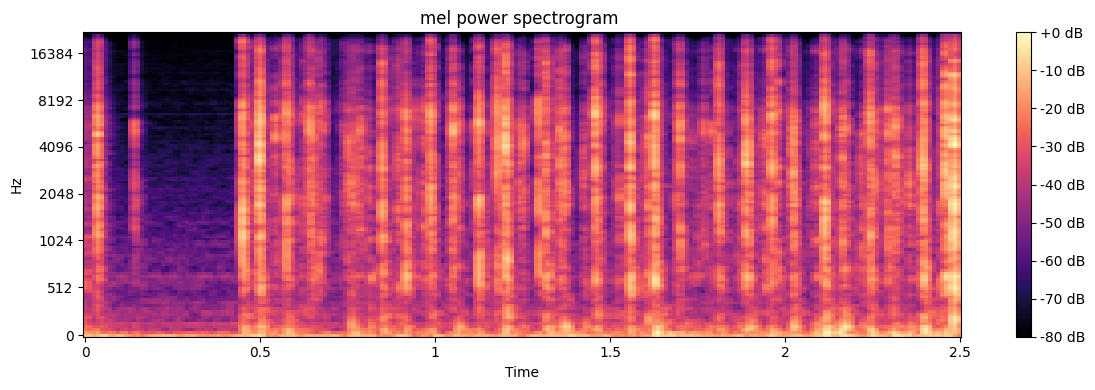

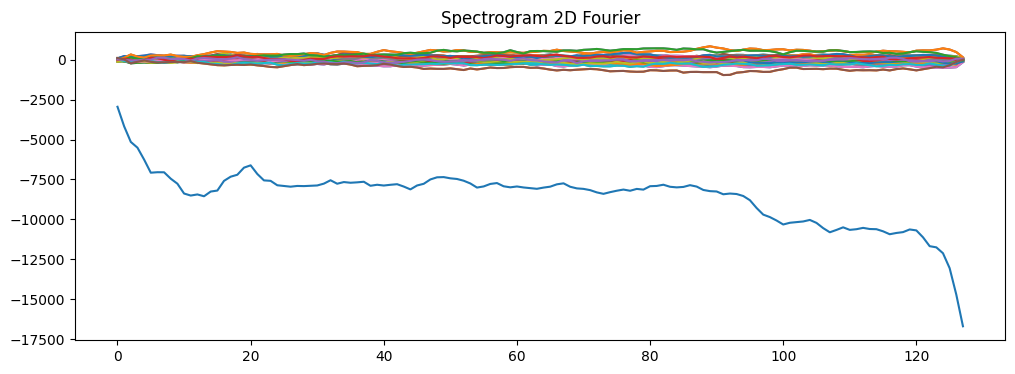

In [7]:
# test audio_search class
search = audio_search()
search.visualize_spectrogram('./ESC-50-master/audio/1-137-A-32.wav')
search.visualize_spectrogram2d_fourier('./ESC-50-master/audio/1-137-A-32.wav')

In [8]:
# hyperperameters for fourier transform

In [9]:


# VAE from huggingface transfomers https://huggingface.co/Fraser/transformer-vae
class VAE(nn.Module):
    def __init__(self, model_name, device, latent_dim=128, max_seq_length=512):
        super(VAE, self).__init__()
        self.model_name = model_name
        self.device = device
        self.latent_dim = latent_dim
        self.max_seq_length = max_seq_length
        self.model = AutoModel.from_pretrained(model_name)
        self.encoder = nn.Sequential(
            nn.Linear(self.model.config.hidden_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 2 * latent_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, self.model.config.hidden_size),
        )

    def encode(self, x):
        return self.encoder(x)

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.model(x)[0]
        x = x[:, 0, :]
        mu_logvar = self.encode(x).view(-1, 2, self.latent_dim)
        mu = mu_logvar[:, 0, :]
        logvar = mu_logvar[:, 1, :]
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        BCE = F.mse_loss(recon_x, x, reduction='sum')
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return BCE + KLD

    def train(self, train_loader, optimizer, epoch):
        self.train()
        train_loss = 0
        for batch_idx, data in enumerate(train_loader):
            data = data.to(self.device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = self(data)
            loss = self.loss_function(recon_batch, data, mu , logvar)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader),
                    loss.item() / len(data)))
        print('====> Epoch: {} Average loss: {:.4f}'.format(
                epoch, train_loss / len(train_loader.dataset)))
   
model = VAE('bert-base-uncased', device, latent_dim=128, max_seq_length=512)

Downloading: 100%|██████████| 570/570 [00:00<00:00, 1.18MB/s]
Downloading: 100%|██████████| 440M/440M [00:11<00:00, 38.0MB/s] 
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
